<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/_11KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
# Download 10 years of Gold Fields stock data
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

# Keep required features (including Volume)
df = data[['Close', 'High', 'Low', 'Open', 'Volume']].copy()

# Create target variable: 1 if next day's close > today's close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop last row (since it has no next day target)
df = df.dropna()

df.tail()

/tmp/ipython-input-3287618951.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Target
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,
Date,,,,,,
2024-12-20,25710.158203,25726.155191,24762.336699,25351.225798,5006397,0
2024-12-23,24765.335938,25806.139923,24680.351943,25310.233317,1293370,1
2024-12-24,25406.214844,25571.183773,24765.335551,25085.275291,334453,0
2024-12-27,25074.277344,25918.118409,24735.341181,25105.271506,817916,0
2024-12-30,24805.328125,25098.272951,24517.382357,24827.323982,1012028,0


In [54]:
# Split train (2013-01-01 to 2023-12-31) and test (2024-01-01 to 2024-12-31)
train_df = df.loc["2013-01-01":"2023-12-31"]
test_df  = df.loc["2024-01-01":"2024-12-31"]

# Features and target
X_train = train_df[['Close', 'High', 'Low', 'Open', 'Volume']]
y_train = train_df['Target']
X_test  = test_df[['Close', 'High', 'Low', 'Open', 'Volume']]
y_test  = test_df['Target']


In [55]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [56]:
# Train KNN with k=5 (you can tune this later)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)


KNeighborsClassifier()

Accuracy: 0.5582329317269076

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.68      0.59       115
           1       0.62      0.46      0.53       134

    accuracy                           0.56       249
   macro avg       0.57      0.57      0.56       249
weighted avg       0.57      0.56      0.55       249



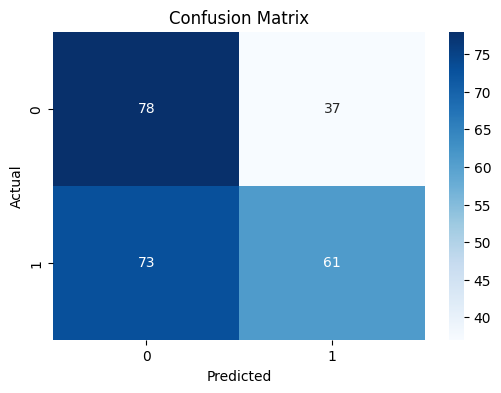

In [57]:
# Predictions
y_pred = knn.predict(X_test_scaled)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


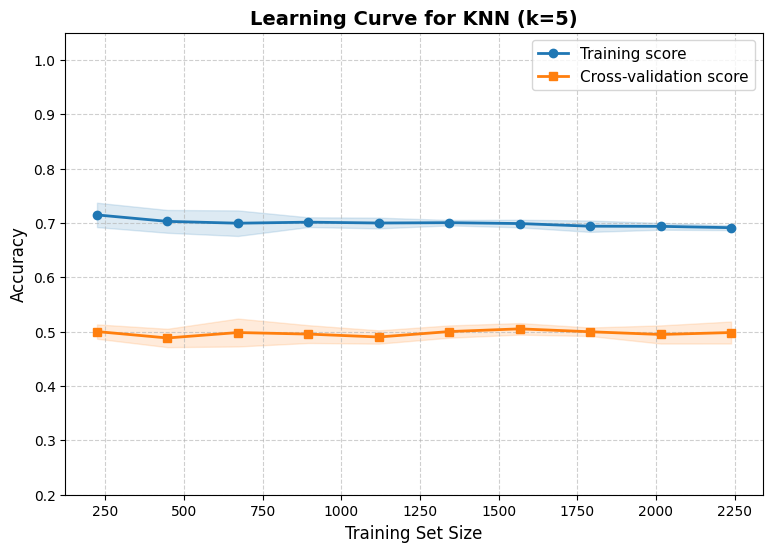

In [59]:
from sklearn.model_selection import learning_curve

# Pick best_k from tuning (or set manually)
best_k = 5
knn = KNeighborsClassifier(n_neighbors=best_k)

# Step 1: Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    knn, X_train_scaled, y_train,
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True, random_state=42
)

# Step 2: Compute means and stds
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

# Step 3: Styled Plot
plt.figure(figsize=(9,6))

# Training curve (blue)
plt.plot(train_sizes, train_mean, 'o-', color="tab:blue", label="Training score", linewidth=2, markersize=6)
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15, color="tab:blue")

# Cross-validation curve (orange)
plt.plot(train_sizes, test_mean, 's-', color="tab:orange", label="Cross-validation score", linewidth=2, markersize=6)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.15, color="tab:orange")

# Labels and title
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title(f"Learning Curve for KNN (k={best_k})", fontsize=14, fontweight="bold")

# Grid and legend
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=11, loc="best")
plt.ylim(0.2, 1.05)

plt.show()


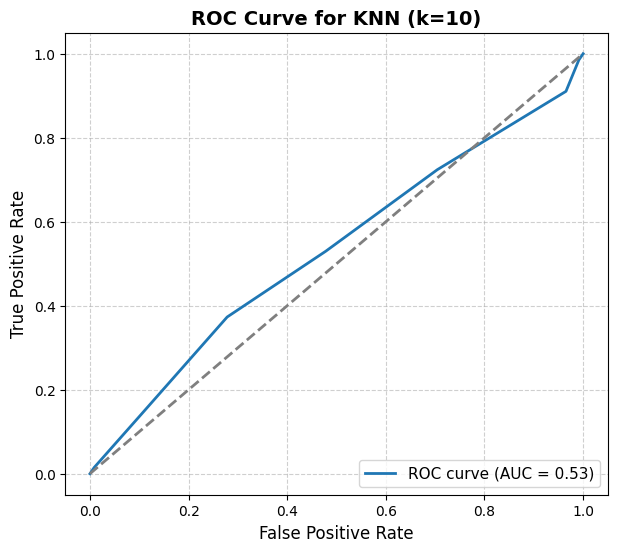

In [61]:
from sklearn.metrics import roc_curve, auc

# 1. Fit KNN (use best_k or any chosen value)
best_k = 10
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# 2. Predict probabilities (for class 1 = stock up)
y_prob = knn.predict_proba(X_test_scaled)[:, 1]

# 3. Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 4. Plot ROC
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color="tab:blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="tab:gray", lw=2, linestyle="--")  # baseline

# Labels and style
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title(f"ROC Curve for KNN (k={best_k})", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [62]:
from sklearn.metrics import roc_auc_score

# Fit model first (if not already fitted)
best_k = 10
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# Get predicted probabilities for class 1
y_prob = knn.predict_proba(X_test_scaled)[:, 1]

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)


AUC Score: 0.5308890330953926
